In [ ]:
!pip install -U sentence-transformers
!pip install feedparser requests scikit-learn googletrans==4.0.0-rc1 sentence-transformers
!pip install newsapi
!pip install newsapi-python
!pip install --upgrade transformers
!pip install beautifulsoup4
!pip install requests_html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
from googletrans import Translator
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

def translate_and_calculate_similarity(query, sentences):
    # translated_sentences = [translate_to_english(sentence, 'auto') for sentence in sentences]
    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # model = BertModel.from_pretrained('bert-base-uncased')
    # model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # query_encoding = tokenizer(query, return_tensors='pt', padding=True, truncation=True)
    # with torch.no_grad():
    #     query_embedding = model(**query_encoding).last_hidden_state.mean(dim=1).squeeze(0)

    # similarity_scores = []
    # for translated_sentence in translated_sentences:
    #     sentence_encoding = tokenizer(translated_sentence, return_tensors='pt', padding=True, truncation=True)
    #     with torch.no_grad():
    #         sentence_embedding = model(**sentence_encoding).last_hidden_state.mean(dim=1).squeeze(0)
    #     similarity_score = cosine_similarity(query_embedding.unsqueeze(0), sentence_embedding.unsqueeze(0))[0][0]
    #     similarity_scores.append(similarity_score)

    # return similarity_scores
    # Load the SentenceTransformer model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # Encode the query and sentences
    query_embedding = model.encode(query, convert_to_tensor=True)
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

    # Calculate cosine similarity between query and sentences
    similarity_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]

    return similarity_scores




WITH CONTENT, TRANSLATE PERFORM SIMILARITY

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = categories = [
    "Politics",
    "Business",
    "Technology",
    "Sports",
    "Entertainment",
    "Health",
    "Science",
    "Environment",
    "Education",
    "Finance",
    "Crime",
    "Lifestyle",
    "Travel",
    "Weather",
    "Culture",
    "Religion",
    "Food",
    "Fashion",
    "Arts",
    "Opinions"]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set language to French
    language = 'fr'

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define query parameters
    params = {
        'q': category,
        'pageSize': page_size,
        'language': language,
        'apiKey': api_key,
        'from': start_date_str,
        'to': end_date_str,
    }

    # Make request to News API
    response = requests.get(news_api_endpoint, params=params)
    articles_data = response.json()
    # Assuming 'articles_data' is the response JSON object from the News API

    # Parse articles data
    relevant_articles = []
    for article in articles_data['articles']:
        title = article['title']
        url = article['url']
        content = article['content']
        source_language = 'fr'  # Assume source language is French
        translated_title = translate_to_english(title, source_language)
        similarity_score = calculate_similarity_score(query, translated_title)
        if similarity_score > 0.1:  # Adjust the threshold as needed
            article_info = {
                'title': translated_title,
                'language': 'French',
                'similarity_score': similarity_score,
                'url': url,
                'content':content
            }
            relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Assuming top_relevant_articles is a list of dictionaries containing articles
    top_relevant_articles = relevant_articles[:10]
    for article in top_relevant_articles:
        content = article['content']
        # Split the content into sentences
        sentences = content.split('.')
        # Get the first 5-6 sentences (you can adjust the range as needed)
        sentences = sentences[:6]
        print(sentences)
        # Translate sentences to English
        translated_sentences = [translate_to_english(sentence, 'auto') for sentence in sentences]
        # Calculate similarity scores for translated sentences
        content_similarity_scores = translate_and_calculate_similarity(query, translated_sentences)
        # Add similarity scores to article dictionary
        article['content_similarity_scores'] = content_similarity_scores
        article['new_content'] = translated_sentences

    # Sort top_relevant_articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: max(x['content_similarity_scores']), reverse=True)

    # Get the top 3 relevant articles based on cosine similarity
    top_3_relevant_articles = top_relevant_articles[:3]

    # Retrieve images and captions

    for article in top_3_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_3_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'whats going on in germany'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("Content:", article['new_content'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Culture
['Pendant longtemps, la conservation de leurs planches était source dinquiétude pour les mangakas', ' Dordinaire, après la publication des uvres, les maisons dédition restituent les originaux aux artistes… [+2302 chars]']
['La lecture de ce contenu est susceptible dentraîner un dépôt de cookies de la part de lopérateur tiers qui lhéberge', ' Compte-tenu des choix que vous avez exprimés en matière de dépôt de cookies, nous … [+5126 chars]']
['Bicycle Day is a global holiday on April 19th celebrating the psychedelic revolution[1] and commemorating the first psychedelic trip on LSD by Dr', ' Albert Hofmann in 1943, in tandem with his famous bi… [+5676 chars]']
['Les cookies et technologies similaires que nous utilisons sur Mediapart sont de différentes natures et nous permettent de poursuivre différentes finalités', ' \r\nCertains sont nécessaires au fonctionneme… [+1247 chars]']
['Les cookies et technologies similaires que nous utilisons sur Mediapart sont de différentes natures 

WITH DESCRIPTION, TRANSLATE AND COSINE SIMILARITY

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = categories = [
    "Politics",
    "Business",
    "Technology",
    "Sports",
    "Entertainment",
    "Health",
    "Science",
    "Environment",
    "Education",
    "Finance",
    "Crime",
    "Lifestyle",
    "Travel",
    "Weather",
    "Culture",
    "Religion",
    "Food",
    "Fashion",
    "Arts",
    "Opinions"]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set language to French
    language = 'fr'

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define query parameters
    params = {
        'q': category,
        'pageSize': page_size,
        'language': language,
        'apiKey': api_key,
        'from': start_date_str,
        'to': end_date_str,
    }

    # Make request to News API
    response = requests.get(news_api_endpoint, params=params)
    articles_data = response.json()
    # Assuming 'articles_data' is the response JSON object from the News API

    # Parse articles data
    relevant_articles = []
    for article in articles_data['articles']:
        title = article['title']
        url = article['url']
        description = article['description']
        source_language = 'fr'  # Assume source language is French
        translated_title = translate_to_english(title, source_language)
        similarity_score = calculate_similarity_score(query, translated_title)
        if similarity_score > 0.1:  # Adjust the threshold as needed
            article_info = {
                'title': translated_title,
                'language': 'French',
                'similarity_score': similarity_score,
                'url': url,
                'content':description
            }
            relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Assuming top_relevant_articles is a list of dictionaries containing articles
    top_relevant_articles = relevant_articles[:10]
    for article in top_relevant_articles:
        content = article['content']
        # Translate sentences to English
        translated_desc = translate_to_english(content, 'auto')
        print(translated_desc)
        # Calculate similarity scores for translated sentences
        content_similarity_scores = translate_and_calculate_similarity(query, translated_desc)
        # Add similarity scores to article dictionary
        article['content_similarity_scores'] = content_similarity_scores
        article['translated_desc'] = translated_desc

    # Sort top_relevant_articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: max(x['content_similarity_scores']), reverse=True)

    # Get the top 3 relevant articles based on cosine similarity
    top_3_relevant_articles = top_relevant_articles[:3]

    # Retrieve images and captions

    for article in top_3_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_3_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'germany'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("Content:", article['translated_desc'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Culture
Comments
[0.2697269916534424]
The Palazzo Reale exhibits two hundred haute couture and high jewelry pieces by Stefano Gabbana and Domenico Dolce.Flamboyant tribute to the crafts of art in the peninsula, the "Alta Moda" explores the Italian heritage and its rich religious imaging.
[0.15453225374221802]
Comments
[0.2697269916534424]
Error retrieving images for article https://www.lemonde.fr/m-styles/article/2024/04/20/a-milan-les-icones-de-mode-de-dolce-gabbana_6228874_4497319.html: 'src'
Top 3 relevant articles:
Article 1:
Title: Depression Rates by Country 2024
Language: French
Similarity Score: 0.19875724613666534
Content: Comments
URL: https://worldpopulationreview.com/country-rankings/depression-rates-by-country
Images:
- Caption: map placeholder
Error displaying image: Invalid URL '/_next/image?url=%2Fsvg_placeholder.png&w=2048&q=75': No scheme supplied. Perhaps you meant https:///_next/image?url=%2Fsvg_placeholder.png&w=2048&q=75?

Article 2:
Title: Bicycle Day (Psychedeli

In [ ]:
import requests
from bs4 import BeautifulSoup
from googletrans import Translator

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'fr' for French).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def extract_first_5_paragraphs(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')[:5]  # Get the first 5 <p> tags
            concatenated_paragraph = ' '.join([p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True)])
            return concatenated_paragraph  # Return the concatenated paragraph
        else:
            print(f"Failed to fetch content from {url}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching content from {url}: {e}")
        return None

# web_url = "https://www.frandroid.com/marques/byd/1998896_byd-tort-le-cou-aux-idees-recues-sur-les-voitures-chinoises-avec-ce-modele-a-lhabitacle-allechant"





TITLE+DESC, DISPLAYING ACTUAL CONTENT IN PARA


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Culture
Error retrieving images for article https://www.lemonde.fr/m-styles/article/2024/04/20/a-milan-les-icones-de-mode-de-dolce-gabbana_6228874_4497319.html: 'src'
Error retrieving images for article https://www.01net.com/actualites/le-gouvernement-lance-deux-missions-pour-mieux-remunerer-les-artistes-face-a-lia.html: list index out of range
Top 6 relevant articles:
Article 1:
Title: Depression Rates by Country 2024
Language: French
Similarity Score: 0.19083748757839203
Description: None
Content: MAP Options 2
5 3 3
5 4
URL: https://worldpopulationreview.com/country-rankings/depression-rates-by-country
Images:
- Caption: map placeholder
Error displaying image: Invalid URL '/_next/image?url=%2Fsvg_placeholder.png&w=2048&q=75': No scheme supplied. Perhaps you meant https:///_next/image?url=%2Fsvg_placeholder.png&w=2048&q=75?

Article 2:
Title: Bicycle Day (Psychedelic Holiday)
Language: French
Similarity Score: 0.150861918926239
Description: None
Content: Bicycle dayis an informant ce

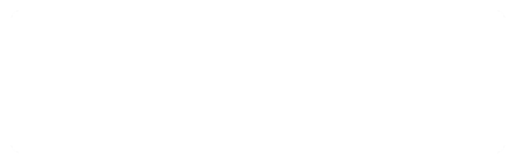


Article 4:
Title: The Japanese government is finally mobilizing for the conservation of manga boards
Language: French
Similarity Score: tensor([0.1327])
Description: In response to the rise in popularity of Japanese comics, the country's culture agency launched a project aimed at keeping manga boards, whose management was entrusted to the artists so far.
Content: In response to the rise in popularity of Japanese comics, the country's culture agency launched a project aimed at keeping manga boards, whose management was entrusted to the artists so far
For a long time, the conservation of their boards was a source of concern for mangakas
Usually, after the publication of the works, the publishing houses restore the originals to the artists, whose families often find it difficult to manage these archives, especially after the death of mangakas
So much so that some of these boards are sold at auction or are even abandoned
A sign of the now global popularity of the Japanese manga, in 2018, 

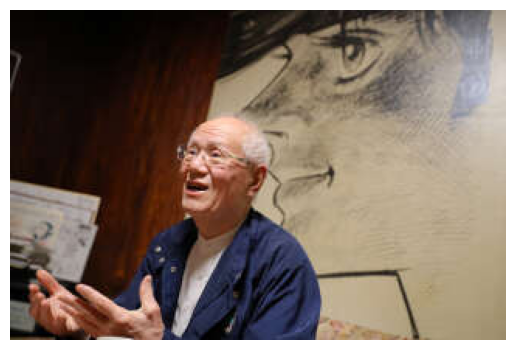


Article 5:
Title: In Milan, Dolce & Gabbana fashion icons
Language: French
Similarity Score: tensor([0.1191])
Description: The Palazzo Reale exhibits two hundred haute couture and high jewelry pieces by Stefano Gabbana and Domenico Dolce.Flamboyant tribute to the crafts of art in the peninsula, the "Alta Moda" explores the Italian heritage and its rich religious imaging.
Content: Consult the newspaper at the SNCF, an end-of-career system which cancels part of the reform of retirement stores without cases: Amazon reveals Tiktok: the United States between "yellow danger" and "young danger" Energy: "plus thembanks finance fossil fuels, the less they help the economic system to get out of its dependence ”
URL: https://www.lemonde.fr/m-styles/article/2024/04/20/a-milan-les-icones-de-mode-de-dolce-gabbana_6228874_4497319.html
No images found for this article.

Article 6:
Title: The government is launching two missions to better pay the artists against AI
Language: French
Similarity Score: t

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = categories = [
    "Politics",
    "Business",
    "Technology",
    "Sports",
    "Entertainment",
    "Health",
    "Science",
    "Environment",
    "Education",
    "Finance",
    "Crime",
    "Lifestyle",
    "Travel",
    "Weather",
    "Culture",
    "Religion",
    "Food",
    "Fashion",
    "Arts",
    "Opinions"]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set language to French
    language = 'fr'

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define query parameters
    params = {
        'q': category,
        'pageSize': page_size,
        'language': language,
        'apiKey': api_key,
        'from': start_date_str,
        'to': end_date_str,
    }

    # Make request to News API
    response = requests.get(news_api_endpoint, params=params)
    articles_data = response.json()
    # Assuming 'articles_data' is the response JSON object from the News API

    # Parse articles data
    relevant_articles = []
    for article in articles_data['articles']:
        title = article['title']
        url = article['url']
        description = article['description']
        source_language = 'fr'  # Assume source language is French
        translated_title = translate_to_english(title, source_language)
        similarity_score = calculate_similarity_score(query, translated_title)
        if similarity_score > 0.1:  # Adjust the threshold as needed
            article_info = {
                'title': translated_title,
                'language': 'French',
                'similarity_score': similarity_score,
                'url': url,
                'description':description
            }
            relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Assuming top_relevant_articles is a list of dictionaries containing articles
    top_relevant_articles = relevant_articles[:10]
    for article in top_relevant_articles:
        content = article['description']
        # Translate sentences to English
        if content =="Comments":
          article['translated_desc']= "None"
          continue
        else:
          translated_desc = translate_to_english(content, 'auto')
          # print(translated_desc)
          # Calculate similarity scores for translated sentences
          content_similarity_scores = translate_and_calculate_similarity(query, translated_desc)
          # Add similarity scores to article dictionary
          # print(content_similarity_scores)
          article['similarity_score'] = content_similarity_scores
          article['translated_desc'] = translated_desc

    # Sort top_relevant_articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Get the top 3 relevant articles based on cosine similarity
    top_6_relevant_articles = top_relevant_articles[:6]

    # Retrieve images and captions
    for article in top_6_relevant_articles:
        article_url = article['url']
        concatenated_paragraph = extract_first_5_paragraphs(article_url)
        if concatenated_paragraph and concatenated_paragraph.strip():  # Check if the concatenated paragraph is not empty
            translated_paragraph = translate_to_english(concatenated_paragraph, 'fr')
            translated_sentences = translated_paragraph.split('.')  # Split into sentences
            translated_text = '\n'.join([sentence.strip() for sentence in translated_sentences if sentence.strip()])
            article['actual_content'] = translated_text
        else:
            print("No paragraphs extracted from the webpage.")


    for article in top_6_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_6_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'whats going on in germany'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("Description:", article['translated_desc'])
        print("Content:", article['actual_content'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


TITLE,DESC + PRINTING PARA SIMILARITY + semantic similarity



The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Opinions
Error retrieving images for article https://atlantico.fr/article/video/annulation-de-la-conference-de-jean-luc-melenchon-a-lille-retrouvez-le-debat-entre-jean-sebastien-ferjou-et-manuel-bompard-bfmtv-universite-lille-rima-hassan-liberte-d-expression-arguments-palestine-gaza-medias-la-france-insoumise: list index out of range
Error retrieving images for article https://www.lemonde.fr/idees/article/2024/04/19/quand-les-gouvernements-et-la-societe-civile-se-reunissent-pour-cocreer-des-dispositifs-qui-impliquent-les-citoyens-cela-conduit-a-de-meilleures-politiques_6228747_3232.html: 'src'
Top 6 relevant articles:
Article 1:
Title: Cancellation of Jean-Luc Mélenchon's conference in Lille: Find the debate between Jean-Sébastien Ferjou and Manuel Bompard
Language: French
Similarity Score: tensor([0.1823])
para sim score: tensor([0.1653])
semantic para score: 0.14488288760185242
Description: The cancellation of the conference of Rima Hassan and Jean-Luc Mélenchon in Lille this week re

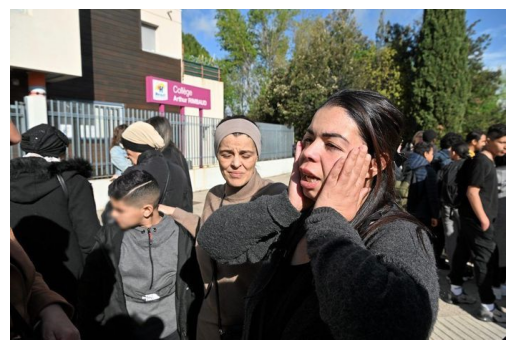


Article 3:
Title: Free Stib, wearing the veil, ritual slaughter: what are the positions of the parties for the Brussels region?Do the electoral test and discover those who get closest to your opinions
Language: French
Similarity Score: tensor([0.1633])
para sim score: tensor([0.2965])
semantic para score: 0.2646717429161072
Description: On June 9, there is a triple election in Belgium: regional, federal and European.

To help you ...
Content: Elections 2024 On June 9, there is in Belgium a triple election: regional, federal and European
To help you find your way around and refine your choice, RTBF posted on Monday 15 Avrilson Electoral Test
This takes up questions about all levels of power
But certain challenges are specific to a geographical area: in the Brussels region, the questions concerning the STIB, the wearing of the veil, the ritual slaughter or the obligations of the unemployed have agitated the debates in recent months
What are the parties that are closest to your positions

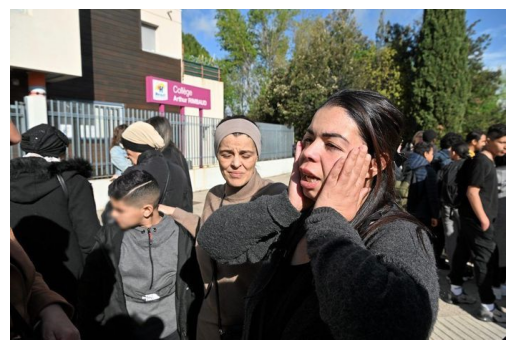

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = categories = [
    "Politics",
    "Business",
    "Technology",
    "Sports",
    "Entertainment",
    "Health",
    "Science",
    "Environment",
    "Education",
    "Finance",
    "Crime",
    "Lifestyle",
    "Travel",
    "Weather",
    "Culture",
    "Religion",
    "Food",
    "Fashion",
    "Arts",
    "Opinions"]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set language to French
    language = 'fr'

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define query parameters
    params = {
        'q': category,
        'pageSize': page_size,
        'language': language,
        'apiKey': api_key,
        'from': start_date_str,
        'to': end_date_str,
    }

    # Make request to News API
    response = requests.get(news_api_endpoint, params=params)
    articles_data = response.json()
    # Assuming 'articles_data' is the response JSON object from the News API

    # Parse articles data
    relevant_articles = []
    for article in articles_data['articles']:
        title = article['title']
        url = article['url']
        description = article['description']
        source_language = 'fr'  # Assume source language is French
        translated_title = translate_to_english(title, source_language)
        similarity_score = calculate_similarity_score(query, translated_title)
        if similarity_score > 0.1:  # Adjust the threshold as needed
            article_info = {
                'title': translated_title,
                'language': 'French',
                'similarity_score': similarity_score,
                'url': url,
                'description':description
            }
            relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Assuming top_relevant_articles is a list of dictionaries containing articles
    top_relevant_articles = relevant_articles[:10]
    for article in top_relevant_articles:
        content = article['description']
        # Translate sentences to English
        if content =="Comments":
          article['translated_desc']= "None"
          continue
        else:
          translated_desc = translate_to_english(content, 'auto')
          # print(translated_desc)
          # Calculate similarity scores for translated sentences
          content_similarity_scores = translate_and_calculate_similarity(query, translated_desc)
          # Add similarity scores to article dictionary
          # print(content_similarity_scores)
          article['similarity_score'] = content_similarity_scores
          article['translated_desc'] = translated_desc

    # Sort top_relevant_articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Get the top 3 relevant articles based on cosine similarity
    top_6_relevant_articles = top_relevant_articles[:6]

    # Retrieve images and captions
    for article in top_6_relevant_articles:
        article_url = article['url']
        semantic_score = extract_semantic_paragraphs(article_url,source_language)
        article['semantic_score']=semantic_score
        concatenated_paragraph = extract_first_5_paragraphs(article_url)
        if concatenated_paragraph and concatenated_paragraph.strip():  # Check if the concatenated paragraph is not empty
            translated_paragraph = translate_to_english(concatenated_paragraph, 'fr')
            para_similarity_score = translate_and_calculate_similarity(query,translated_paragraph)
            article['para_sim_score'] = para_similarity_score
            translated_sentences = translated_paragraph.split('.')  # Split into sentences
            translated_text = '\n'.join([sentence.strip() for sentence in translated_sentences if sentence.strip()])
            article['actual_content'] = translated_text
        else:
            print("No paragraphs extracted from the webpage.")


    for article in top_6_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_6_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'ukraine war'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("para sim score:", article['para_sim_score'])
        print("semantic para score:", article['semantic_score'])
        print("Description:", article['translated_desc'])
        print("Content:", article['actual_content'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


# title+desc for choosing top 10, semantic para for top 5.


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Opinions
0.16894738376140594 0.24523413181304932
0.12192441523075104 0.22562426328659058
0.0838128998875618 0.20958738029003143
0.16328728199005127 0.1825784295797348
0.18229228258132935 0.15104882419109344
0.07886803895235062 0.1328067183494568
0.15393146872520447 0.1127871423959732
0.08097051084041595 0.09527108818292618
No paragraphs extracted from the webpage.
Error retrieving images for article https://www.lemonde.fr/idees/article/2024/04/19/quand-les-gouvernements-et-la-societe-civile-se-reunissent-pour-cocreer-des-dispositifs-qui-impliquent-les-citoyens-cela-conduit-a-de-meilleures-politiques_6228747_3232.html: 'src'
Error retrieving images for article https://atlantico.fr/article/video/annulation-de-la-conference-de-jean-luc-melenchon-a-lille-retrouvez-le-debat-entre-jean-sebastien-ferjou-et-manuel-bompard-bfmtv-universite-lille-rima-hassan-liberte-d-expression-arguments-palestine-gaza-medias-la-france-insoumise: list index out of range
Top 5 relevant articles:
Article 1:
Title

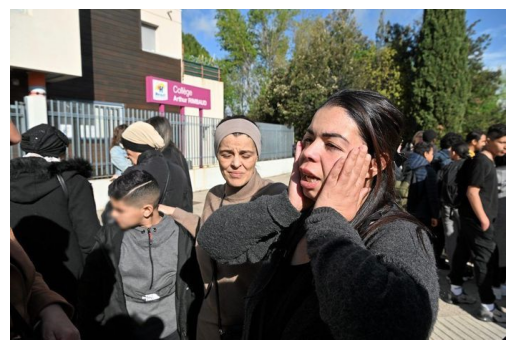


Article 4:
Title: "Transmania", Conferences of Mélenchon on Palestine: do you want to be republicans?Let them express themselves!
Language: French
Similarity Score: 0.20958738029003143
para sim score: 0.01927751488983631
semantic para score: 0.15879659354686737
Description: An appetite for frantic censorship threatens to devour freedom of expression in France.It seems to have become inconceivable to let an opposite point of view to benefit from a public forum, as shown by the withdrawal of advertisements for the book "Transm ...
Content: Men menu Connection account
URL: https://www.marianne.net/politique/transmania-conferences-de-melenchon-sur-la-palestine-vous-voulez-etre-republicains-laissez-les-s-exprimer
Images:
- Caption: "All day long, it was insults": behind the Samara, stupidity, ghetto and social networks affair


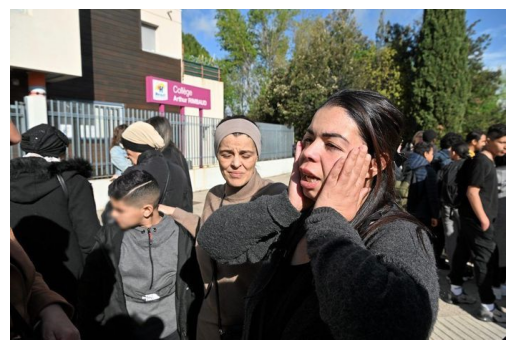


Article 5:
Title: Cancellation of Jean-Luc Mélenchon's conference in Lille: Find the debate between Jean-Sébastien Ferjou and Manuel Bompard
Language: French
Similarity Score: 0.18229228258132935
para sim score: 0.16526193916797638
semantic para score: 0.14488288760185242
Description: The cancellation of the conference of Rima Hassan and Jean-Luc Mélenchon in Lille this week revived the debate on freedom of expression.As part of the 90-minute Info program, Jean-Sébastien Ferjou debated with Manuel Bompard, national coordinator ...
Content: A conference by Jean-Luc Mélenchon and the Franco-Palestinian activist Rima Hassan scheduled for Thursday, April 18 was canceled by the University of Lille, who considered that "the conditions are no longer met to guarantee the serenity of the debates"
The University of Lille announced this Wednesday the cancellation of the conference, on its premises, of the leader of rebellious France, Jean-Luc Mélenchon, and Rima Hassan, who is a candidate in 7th

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = categories = [
    "Politics",
    "Business",
    "Technology",
    "Sports",
    "Entertainment",
    "Health",
    "Science",
    "Environment",
    "Education",
    "Finance",
    "Crime",
    "Lifestyle",
    "Travel",
    "Weather",
    "Culture",
    "Religion",
    "Food",
    "Fashion",
    "Arts",
    "Opinions"]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set language to French
    language = 'fr'

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define query parameters
    params = {
        'q': category,
        'pageSize': page_size,
        'language': language,
        'apiKey': api_key,
        'from': start_date_str,
        'to': end_date_str,
    }

    # Make request to News API
    response = requests.get(news_api_endpoint, params=params)
    articles_data = response.json()
    # Assuming 'articles_data' is the response JSON object from the News API

    # Parse articles data
    relevant_articles = []
    for article in articles_data['articles']:
        title = article['title']
        url = article['url']
        description = article['description']
        source_language = 'fr'  # Assume source language is French
        translated_title = translate_to_english(title, source_language)
        similarity_score = calculate_similarity_score(query, translated_title)
        if similarity_score > 0.07:  # Adjust the threshold as needed
            article_info = {
                'title': translated_title,
                'language': 'French',
                'similarity_score': similarity_score,
                'url': url,
                'description':description
            }
            relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Assuming top_relevant_articles is a list of dictionaries containing articles
    top_relevant_articles = relevant_articles[:20]
    for article in top_relevant_articles:
        content = article['description']
        # Translate sentences to English
        if content =="Comments":
          article['translated_desc']= "None"
          continue
        else:
          translated_desc = translate_to_english(content, 'auto')
          # print(translated_desc)
          # Calculate similarity scores for translated sentences
          content_similarity_scores = calculate_similarity_score(query, translated_desc)
          # Add similarity scores to article dictionary
          print(content_similarity_scores,article['similarity_score'])
          if content_similarity_scores is not None:
            if float(content_similarity_scores) > float(article['similarity_score']):
              article['similarity_score'] = content_similarity_scores
          article['translated_desc'] = translated_desc

    # Sort top_relevant_articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Get the top 3 relevant articles based on cosine similarity
    top_10_relevant_articles = top_relevant_articles[:10]

    # Retrieve images and captions
    for article in top_10_relevant_articles:
        article_url = article['url']
        semantic_score = extract_semantic_paragraphs(article_url,source_language)
        if semantic_score is not None:
          article['semantic_score']=semantic_score
        else:
          article['semantic_score']=article['similarity_score']
        concatenated_paragraph = extract_first_5_paragraphs(article_url)
        if concatenated_paragraph and concatenated_paragraph.strip():  # Check if the concatenated paragraph is not empty
            translated_paragraph = translate_to_english(concatenated_paragraph, source_language)
            para_similarity_score = calculate_similarity_score(query,translated_paragraph)
            article['para_sim_score'] = para_similarity_score
            translated_sentences = translated_paragraph.split('.')  # Split into sentences
            translated_text = '\n'.join([sentence.strip() for sentence in translated_sentences if sentence.strip()])
            article['actual_content'] = translated_text
        else:
            print("No paragraphs extracted from the webpage.")

     #sort based on semantic similarity scores
    # Assuming top_10_relevant_articles is your list of dictionaries containing articles

    top_10_relevant_articles.sort(key=lambda x: x['semantic_score'] if x['semantic_score'] is not None else 0, reverse=True)


     #Get the top 5 relevant articles y
    top_5_relevant_articles = top_10_relevant_articles[:5]

    for article in top_5_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_5_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'ukraine war'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("para sim score:", article['para_sim_score'])
        print("semantic para score:", article['semantic_score'])
        print("Description:", article['translated_desc'])
        print("Content:", article['actual_content'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


#lANGUAGES

In [ ]:
import requests
from sentence_transformers import SentenceTransformer, util
from googletrans import Translator
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from transformers import pipeline

def translate_to_english(text, source_language):
    """
    Translate text to English using Google Translate API.

    Args:
    - text (str): The text to be translated.
    - source_language (str): The source language code of the text (e.g., 'kn' for Kannada, 'ta' for Tamil).

    Returns:
    - translated_text (str): The translated text in English.
    """
    translator = Translator()
    translated = translator.translate(text, src=source_language, dest='en')
    translated_text = translated.text
    return translated_text

def classify_query(query):
    classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
    hypothesis_template = 'This text is about {}.'
    labels = [
        "Politics", "Business", "Technology", "Sports", "Entertainment", "Health",
        "Science", "Environment", "Education", "Finance", "Crime", "Lifestyle",
        "Travel", "Weather", "Culture", "Religion", "Food", "Fashion", "Arts", "Opinions"
    ]

    prediction = classifier(query, labels, hypothesis_template=hypothesis_template, multi_class=True)
    predicted_label = prediction['labels'][0]  # Assuming the highest scored label is the predicted category
    print(predicted_label)
    return predicted_label

def get_articles(query, page_size=10):
    """
    Retrieve relevant articles from French and Spanish news sources based on a query using News API.

    Args:
    - query (str): The search query in English.
    - page_size (int): The maximum number of articles to return (default is 10).

    Returns:
    - articles (list): A list of dictionaries, each containing information about a relevant article.
    """
    category = classify_query(query)

    # Define News API endpoint and API key
    api_key = 'fd8d3b8bf4654a15b631eea5066bc001'
    news_api_endpoint = 'https://newsapi.org/v2/everything'

    # Set languages to French and Spanish
    languages = ['de', 'it']

    # Calculate the date range for the past 24 hours
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Initialize list to store all relevant articles
    relevant_articles = []

    for language in languages:
        # Define query parameters for each language
        params = {
            'q': category,
            'pageSize': page_size,
            'language': language,
            'apiKey': api_key,
            'from': start_date_str,
            'to': end_date_str,
        }

        # Make request to News API
        response = requests.get(news_api_endpoint, params=params)
        articles_data = response.json()

        # Parse articles data for the current language
        for article in articles_data['articles']:
            title = article['title']
            url = article['url']
            description = article['description']

            # Translate title to English for similarity score calculation
            translated_title = translate_to_english(title, language)

            # Calculate similarity score between query and translated title
            similarity_score = calculate_similarity_score(query, translated_title)

            # Filter articles based on similarity score threshold
            if similarity_score > 0.07:  # Adjust the threshold as needed
                article_info = {
                    'title': translated_title,
                    'language': language,  # Store the language of the article
                    'similarity_score': similarity_score,
                    'url': url,
                    'description': description
                }
                relevant_articles.append(article_info)

    # Sort articles by similarity score (descending)
    relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Limit to top relevant articles
    top_relevant_articles = relevant_articles[:20]  # Adjust the number of top articles as needed

    # Process top relevant articles
    for article in top_relevant_articles:
        content = article['description']
        # Translate sentences to English
        if content == "Comments":
            article['translated_desc'] = "None"
            continue
        else:
            translated_desc = translate_to_english(content, 'auto')
            content_similarity_scores = calculate_similarity_score(query, translated_desc)
            if content_similarity_scores is not None:
                if float(content_similarity_scores) > float(article['similarity_score']):
                    article['similarity_score'] = content_similarity_scores
            article['translated_desc'] = translated_desc

    # Sort top relevant articles based on the highest similarity scores
    top_relevant_articles.sort(key=lambda x: x['similarity_score'], reverse=True)

    # Get the top 5 relevant articles
    top_10_relevant_articles = top_relevant_articles[:10]

    # Retrieve additional data (e.g., semantic scores, images) for the top 5 relevant articles
    for article in top_10_relevant_articles:
        article_url = article['url']
        semantic_score = extract_semantic_paragraphs(article_url, article['language'])
        if semantic_score is not None:
            article['semantic_score'] = semantic_score
        else:
            article['semantic_score'] = article['similarity_score']
        concatenated_paragraph = extract_first_5_paragraphs(article_url)
        if concatenated_paragraph and concatenated_paragraph.strip():
            translated_paragraph = translate_to_english(concatenated_paragraph, article['language'])
            para_similarity_score = calculate_similarity_score(query, translated_paragraph)
            article['para_sim_score'] = para_similarity_score
            translated_sentences = translated_paragraph.split('.')
            translated_text = '\n'.join([sentence.strip() for sentence in translated_sentences if sentence.strip()])
            article['actual_content'] = translated_text
        else:
            print("No paragraphs extracted from the webpage.")

    # Assuming top_10_relevant_articles is your list of dictionaries containing articles

    top_10_relevant_articles.sort(key=lambda x: x['semantic_score'] if x['semantic_score'] is not None else 0, reverse=True)


     #Get the top 5 relevant articles y
    top_5_relevant_articles = top_10_relevant_articles[:5]

    for article in top_5_relevant_articles:
        article_url = article['url']
        try:
            response = requests.get(article_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('img')
            captions = [img['alt'] if 'alt' in img.attrs else None for img in images]
            images_with_captions = [{'url': img['src'], 'caption': translate_to_english(caption, 'auto')} for img, caption in zip(images, captions) if caption]

            # Calculate similarity between query and image captions
            similarity_scores = [calculate_similarity_score(query, img_info['caption']) for img_info in images_with_captions]

            # Get the indices of the 5 most relevant images
            top_indices = sorted(range(len(similarity_scores)), key=lambda i: similarity_scores[i], reverse=True)[:5]

            # Add the 5 most relevant images to the article
            article['images'] = [images_with_captions[i] for i in top_indices]

        except Exception as e:
            print(f"Error retrieving images for article {article_url}: {e}")
            article['images'] = []


    return top_5_relevant_articles

def calculate_similarity_score(query, title):
    """
    Calculate the semantic similarity score between the query and article title.

    Args:
    - query (str): The search query.
    - title (str): The title of the article.

    Returns:
    - similarity_score (float): The semantic similarity score.
    """
    # Use SentenceTransformer to calculate semantic similarity
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    query_embedding = model.encode(query)  # Encode the query
    title_embedding = model.encode(title)  # Encode the article title
    similarity_score = util.pytorch_cos_sim(query_embedding, title_embedding).item()
    return similarity_score

# Example usage:
query = 'What will happen in european elections'
articles = get_articles(query)

if articles:
    print(f"Top {len(articles)} relevant articles:")
    for idx, article in enumerate(articles, start=1):
        print(f"Article {idx}:")
        print("Title:", article['title'])
        print("Language:", article['language'])
        print("Similarity Score:", article['similarity_score'])
        print("para sim score:", article['para_sim_score'])
        print("semantic para score:", article['semantic_score'])
        print("Description:", article['translated_desc'])
        print("Content:", article['actual_content'])
        print("URL:", article['url'])

        # Display the first image that does not encounter an error
        if article['images']:
            print("Images:")
            for img_info in article['images']:
                print("- Caption:", img_info['caption'])
                try:
                    response = requests.get(img_info['url'])
                    img_data = BytesIO(response.content)
                    img_obj = Image.open(img_data)
                    plt.figure()
                    plt.imshow(img_obj)
                    plt.axis('off')
                    plt.show()
                    break  # Stop after displaying the first image
                except Exception as e:
                    print(f"Error displaying image: {e}")
        else:
            print("No images found for this article.")
        print()
else:
    print("No relevant articles found.")


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Politics
Error retrieving images for article https://www.ilfattoquotidiano.it/2024/04/21/il-controllo-dei-vertici-rai-si-fa-ogni-giorno-piu-asfissiante-il-comunicato-dei-giornalisti-rai-letto-in-tv-dopo-il-caso-scurati-lazienda-nessuna-censura/7521116/: 'src'
Top 3 relevant articles:
Article 1:
Title: "The control of the Rai leaders becomes more asphyxiating every day": the press release of Rai journalists read on TV after the dark case.The company: "No censorship"
Language: it
Similarity Score: 0.1465042531490326
para sim score: 0.21399295330047607
semantic para score: 0.17696505784988403
Description: The Usigrai press release, also read this time live by the news, immediately became viral on social networks
The article "The control of the Rai leaders becomes more asphyxiating every day": the press release of Rai journalists read on TV after the dark case.The company:…
Content: A few days after the press release read by journalists in the main national news, in which the assembly of t

In [ ]:
def extract_semantic_paragraphs(url,source_language):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')[:5]  # Get the first 5 <p> tags
            sum=0
            for p in paragraphs:
              text = p.get_text()
              translated_text = translate_to_english(text, source_language)
              sentence_similarity = calculate_similarity_score(query,translated_text)
              sum+=sentence_similarity
              return sum
        else:
            print(f"Failed to fetch content from {url}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching content from {url}: {e}")
        return None

In [ ]:
from traceback import StackSummary
from transformers import pipeline

from transformers import pipeline

def summarisation(text):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summarised_text = summarizer(text, max_length=400, min_length=30, do_sample=False)
    summary = summarised_text[0]['summary_text']
    sentences = summary.split('.')
    formatted_summary = '\n'.join([sentence.strip() for sentence in sentences if sentence.strip()])

    return formatted_summary







In [ ]:
def extract_entire_paragraphs(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')[:10]

            # Concatenate text content of all <p> tags
            concatenated_paragraph = ""
            for paragraph in paragraphs:
                paragraph_text = paragraph.get_text(strip=True)
                if paragraph_text:  # Check if paragraph text is not empty
                    concatenated_paragraph += paragraph_text + " "

            return concatenated_paragraph.strip()  # Return the concatenated paragraph, stripped of extra spaces

        else:
            print(f"Failed to fetch content from {url}. Status code: {response.status_code}")
            return None

    except Exception as e:
        print(f"Error fetching content from {url}: {e}")
        return None